# Permutation Importance vs Random Forest Feature Importance (MDI)

reference.  
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

`random_num` is a high cardinality numerical variable (as many unique values as records).

`random_cat` is a low cardinality categorical variable (3 possible values).

In [2]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

random_seed = 42
rng = np.random.RandomState(seed=random_seed)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=random_seed)

categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=random_seed))
])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [3]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.814


<ipython-input-4-ae7ef6b9e953>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


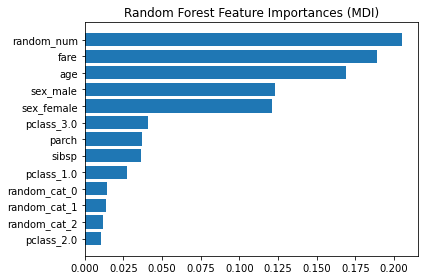

In [4]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

#### (impurity-based) feature importances의 한계
- impurity-based importances are biased towards high cardinality(집합의 크기) features.
  - 연속형 변수, 다양한 종류의 범주형 변수인 경우 중요도가 부풀려진다.
    - cardinality가 높을수록 노드를 나누는 빈도가 높은 경향성.

#### Permutation Importance

![title](feature_importance_disadv.png)

##### Intuition
train data로 모형 학습 후, 특정 feature의 데이터를 shuffle 했을 때, test 데이터 셋에 대한 예측성능을 확인하고 feature importance를 계산한다.  
- feature data shuffle 시 때 모형의 성능이 떨어짐 -> 중요한 feature  
- feature data shuffle 시 때 모형의 성능이 그대로 -> 중요하지 않은 feature


장점
- 사용범위가 넓고 이해하기 쉽다
- 일관된 feature의 중요도를 측정할 수 있다.

단점
- 무작위로 섞기 때문에 계산할 때마다 결과가 달라진다.

reference.  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://hong-yp-ml-records.tistory.com/51 [HONG YP's Data Science BLOG]

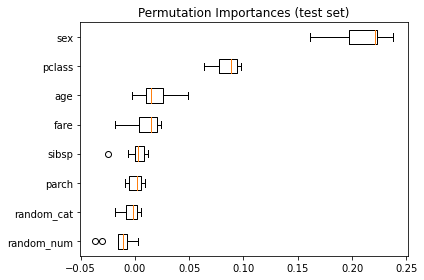

In [5]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=random_seed, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()